# Tree-based models — Recall at threshold 0.3
This notebook trains four tree-based baseline models and evaluates recall at probability threshold 0.5.
Data source: `data/processed/customer_churn_processed.csv`

In [20]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.exceptions import NotFittedError
sns.set(style='whitegrid')

In [21]:
# Load data (adjust path if needed)
from pathlib import Path

# root = Path.cwd().parent
# DATA_PATH = root / 'data' / 'processed' /'customer_churn_processed.csv'
df = pd.read_csv("/content/customer_churn_processed.csv")
# print('loaded', DATA_PATH)
print('shape:', df.shape)
print('columns:', list(df.columns)[:50])

shape: (440833, 52)
columns: ['CustomerID', 'Age', 'Gender', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction', 'Churn', 'CLV', 'Support_Efficiency', 'Payment_Reliability', 'Usage_Score', 'Engagement_Index', 'Spend_per_Interaction', 'Risk_Score', 'Sub_Basic', 'Sub_Premium', 'Sub_Standard', 'Contract_Annual', 'Contract_Monthly', 'Contract_Quarterly', 'TenureGroup_0-12M', 'TenureGroup_12-24M', 'TenureGroup_24-36M', 'TenureGroup_36-48M', 'TenureGroup_48M+', 'AgeGroup_18-30', 'AgeGroup_30-40', 'AgeGroup_40-50', 'AgeGroup_50-60', 'AgeGroup_60+', 'SpendCategory_Low', 'SpendCategory_Medium', 'SpendCategory_High', 'CustomerID__missing_flag', 'Age__missing_flag', 'Last Interaction__missing_flag', 'Tenure__missing_flag', 'Usage Frequency__missing_flag', 'Support Calls__missing_flag', 'Payment Delay__missing_flag', 'Total Spend__missing_flag', 'Churn__missing_flag', 'Risk_Score__missing_flag', 'CLV__missing_flag', 'Support_Efficiency__missing_flag', 

In [22]:
df.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn,...,Payment Delay__missing_flag,Total Spend__missing_flag,Churn__missing_flag,Risk_Score__missing_flag,CLV__missing_flag,Support_Efficiency__missing_flag,Payment_Reliability__missing_flag,Usage_Score__missing_flag,Engagement_Index__missing_flag,Spend_per_Interaction__missing_flag
0,2.0,-0.753326,0,0.448760,-0.210511,0.454549,0.609620,1.247427,0.293052,1.0,...,0,0,0,0,0,0,0,0,0,0
1,3.0,2.059646,0,1.028278,-1.724562,2.083100,-0.601319,-0.309865,-0.986584,1.0,...,0,0,0,0,0,0,0,0,0,0
2,4.0,1.255940,0,-1.000036,-1.375166,0.780259,0.609620,-1.854698,-1.335575,1.0,...,0,0,0,0,0,0,0,0,0,0
3,5.0,1.497051,1,0.390808,0.604748,1.105969,-0.722413,-0.978462,1.689018,1.0,...,0,0,0,0,0,0,0,0,0,0
4,6.0,-1.315921,1,0.043097,0.488282,0.454549,-0.601319,-0.060698,0.642043,1.0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
# Identify numeric and categorical columns
df_work = df.copy()
num_cols = df_work.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_work.select_dtypes(include=['object','category',]).columns.tolist()
print('Numeric cols:', len(num_cols))
print('Categorical cols:', len(cat_cols))

# Impute numerics with median
for c in num_cols:
    if df_work[c].isnull().any():
        med = df_work[c].median()
        df_work[c] = df_work[c].fillna(med)

# Impute categoricals with mode (if available)
for c in cat_cols:
    if df_work[c].isnull().any():
        try:
            mode = df_work[c].mode(dropna=True)[0]
            df_work[c] = df_work[c].fillna(mode)
        except Exception:
            # if mode cannot be determined, fill with string 'missing'
            df_work[c] = df_work[c].fillna('missing')

print(df_work.isnull().sum())

Numeric cols: 33
Categorical cols: 0
CustomerID                             0
Age                                    0
Gender                                 0
Tenure                                 0
Usage Frequency                        0
Support Calls                          0
Payment Delay                          0
Total Spend                            0
Last Interaction                       0
Churn                                  0
CLV                                    0
Support_Efficiency                     0
Payment_Reliability                    0
Usage_Score                            0
Engagement_Index                       0
Spend_per_Interaction                  0
Risk_Score                             0
Sub_Basic                              0
Sub_Premium                            0
Sub_Standard                           0
Contract_Annual                        0
Contract_Monthly                       0
Contract_Quarterly                     0
TenureGroup_0-12M   

In [25]:
print(df_work['TenureGroup_48M+'].dtype)

bool


In [27]:
df=df_work.copy()

In [28]:
# Infer target column (common names)
candidates = [c for c in df.columns if 'churn' in c.lower() or c.lower() in ('target','y','label')]
if len(candidates) >= 1:
    target = candidates[0]
    print('inferred target:', target)
else:
    # fallback to last column
    target = df.columns[-1]
    print('no churn-like column found; using last column as target:', target)

inferred target: Churn


In [29]:
# Simple preprocessing: handle target, encode categoricals
y = df[target].copy()
# map common string labels to 0/1
if y.dtype == 'object' or y.dtype.name == 'category':
    y_lower = y.astype(str).str.lower()
    mapping = {'yes':1,'no':0,'y':1,'n':0,'true':1,'false':0,'1':1,'0':0,'True':1,'False':0,}
    y_mapped = y_lower.map(mapping)
    if y_mapped.isna().sum() == 0:
        y = y_mapped.astype(int)
    else:
        # try numeric coercion
        y = pd.to_numeric(y, errors='coerce').fillna(y)
try:
    y = y.astype(int)
except Exception:
    # leave as-is; some classifiers need numeric labels
    pass


X = df.drop(columns=[target])
# drop constant columns
nunique = X.nunique(dropna=False)
const_cols = list(nunique[nunique <= 1].index)
if const_cols:
    X = X.drop(columns=const_cols)


# one-hot encode object/category columns (trees handle numerics)
obj_cols = X.select_dtypes(include=['object','category']).columns.tolist()
if obj_cols:
    X = pd.get_dummies(X, columns=obj_cols, drop_first=True)
print('features shape after encoding:', X.shape)

features shape after encoding: (440833, 51)


In [30]:
y.isnull().sum()

np.int64(0)

In [31]:
X.isnull().sum()

,0
CustomerID,0
Age,0
Gender,0
Tenure,0
Usage Frequency,0
Support Calls,0
Payment Delay,0
Total Spend,0
Last Interaction,0
CLV,0


In [32]:
# Train/test split (stratify if possible)
try:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
except Exception:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('train/test shapes:', X_train.shape, X_test.shape)

train/test shapes: (352666, 51) (88167, 51)


In [33]:
# Define tree-based baseline models
models = {
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'HistGradientBoosting': HistGradientBoostingClassifier(max_iter=100, random_state=42)
}
results = []
THRESHOLD = 0.3
for name, model in models.items():
    print('\nTraining', name)
    model.fit(X_train, y_train)
    # get probability for positive class if available
    try:
        probs = model.predict_proba(X_test)[:, 1]
        preds = (probs >= THRESHOLD).astype(int)
    except Exception:
        # fallback to predict (some models may not have predict_proba)
        preds = model.predict(X_test)
    rec = recall_score(y_test, preds)
    results.append({'model': name, 'recall': rec})
    print(name, 'recall (threshold', THRESHOLD, '):', rec)


Training DecisionTree
DecisionTree recall (threshold 0.3 ): 0.9998

Training RandomForest
RandomForest recall (threshold 0.3 ): 1.0

Training GradientBoosting
GradientBoosting recall (threshold 0.3 ): 0.99996

Training HistGradientBoosting
HistGradientBoosting recall (threshold 0.3 ): 1.0


                  model   recall
0          RandomForest  1.00000
1  HistGradientBoosting  1.00000
2      GradientBoosting  0.99996
3          DecisionTree  0.99980


/tmp/ipython-input-3993703101.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=res_df, x='recall', y='model', palette='viridis')


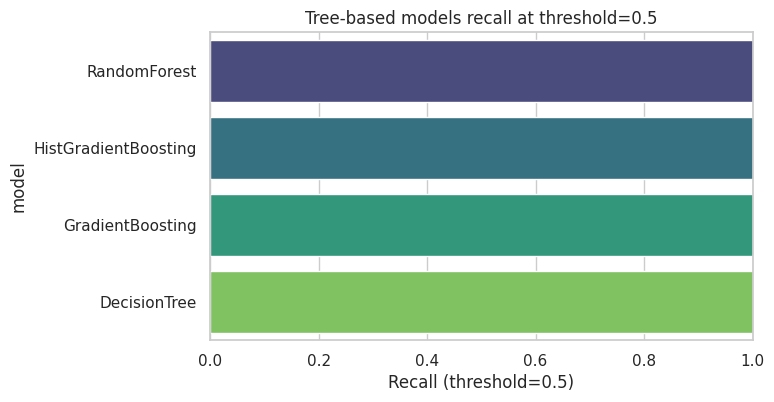

Best model: RandomForest with recall=1.0000


In [34]:
# Summarize results and plot
res_df = pd.DataFrame(results).sort_values('recall', ascending=False).reset_index(drop=True)
print(res_df)
plt.figure(figsize=(7,4))
sns.barplot(data=res_df, x='recall', y='model', palette='viridis')
plt.xlim(0,1)
plt.xlabel('Recall (threshold=0.5)')
plt.title('Tree-based models recall at threshold=0.5')
plt.show()
best = res_df.iloc[0]
print(f"Best model: {best['model']} with recall={best['recall']:.4f}")

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

THRESHOLD = 0.3 # customer chole jwar probability 30% er upore gelei chole jabe mone korbe

rf = RandomForestClassifier(
    n_estimators=300,
    class_weight='balanced',   # handles imbalance for you
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

proba = rf.predict_proba(X_test)[:, 1] # customer chole jwar probability
y_pred = (proba >= THRESHOLD).astype(int)

print(classification_report(y_test, y_pred, digits=3))


from sklearn.metrics import precision_score, recall_score, f1_score

proba = rf.predict_proba(X_test)[:, 1]

print("Threshold tuning for RandomForest")

print(f"{'Thresh':<8}{'Prec_1':<8}{'Rec_1':<8}{'F1_1':<8}")
for thresh in [0.25, 0.30, 0.35, 0.40, 0.45, 0.50]:
    preds = (proba >= thresh).astype(int)
    prec = precision_score(y_test, preds, pos_label=1)
    rec = recall_score(y_test, preds, pos_label=1)
    f1 = f1_score(y_test, preds, pos_label=1)
    print(f"{thresh:<8}{prec:<8.3f}{rec:<8.3f}{f1:<8.3f}")

              precision    recall  f1-score   support

           0      1.000     0.993     0.997     38167
           1      0.995     1.000     0.997     50000

    accuracy                          0.997     88167
   macro avg      0.997     0.997     0.997     88167
weighted avg      0.997     0.997     0.997     88167

Threshold tuning for RandomForest
Thresh  Prec_1  Rec_1   F1_1    
0.25    0.994   1.000   0.997   
0.3     0.995   1.000   0.997   
0.35    0.996   1.000   0.998   
0.4     0.997   1.000   0.999   
0.45    0.998   1.000   0.999   
0.5     0.999   1.000   0.999   


In [37]:
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
import time

lgbm = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Training timer
start_train = time.time()
lgbm.fit(X_train, y_train)
train_time = time.time() - start_train
print(f" Training time: {train_time:.2f} seconds") # important to monitor and training model

# Prediction timer
start_pred = time.time()
proba = lgbm.predict_proba(X_test)[:, 1]
y_pred = (proba >= THRESHOLD).astype(int)
pred_time = time.time() - start_pred
print(f" Prediction time: {pred_time:.4f} seconds") #important to find fast model

# Classification report
print(classification_report(y_test, y_pred, digits=3))

from sklearn.metrics import precision_score, recall_score, f1_score

proba = lgbm.predict_proba(X_test)[:, 1]

print("Threshold tuning for LightGBM")

print(f"{'Thresh':<8}{'Prec_1':<8}{'Rec_1':<8}{'F1_1':<8}")
for thresh in [0.25, 0.30, 0.35, 0.40, 0.45, 0.50]:
    preds = (proba >= thresh).astype(int)
    prec = precision_score(y_test, preds, pos_label=1)
    rec = recall_score(y_test, preds, pos_label=1)
    f1 = f1_score(y_test, preds, pos_label=1)
    print(f"{thresh:<8}{prec:<8.3f}{rec:<8.3f}{f1:<8.3f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 200000, number of negative: 152666
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1890
[LightGBM] [Info] Number of data points in the train set: 352666, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
 Training time: 6.13 seconds
 Prediction time: 0.2235 seconds
              precision    recall  f1-score   support

           0      1.000     1.000     1.000     38167
           1      1.000     1.000     1.000     50000

    accuracy                          1.000     88167
   macro avg      1.000     1.000     1.000     88167
weighted avg      1.000    

In [38]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import time

# Calculate scale_pos_weight for imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss'
)

# Training timer
start_train = time.time()
xgb.fit(X_train, y_train)
train_time = time.time() - start_train
print(f"⏱ Training time: {train_time:.2f} seconds")

# Prediction timer
start_pred = time.time()
proba = xgb.predict_proba(X_test)[:, 1]
y_pred = (proba >= THRESHOLD).astype(int)
pred_time = time.time() - start_pred
print(f"⏱ Prediction time: {pred_time:.4f} seconds")

# Classification report
print(classification_report(y_test, y_pred, digits=3))
from sklearn.metrics import precision_score, recall_score, f1_score

proba = xgb.predict_proba(X_test)[:, 1]

print("Threshold tuning for XGBoost")

print(f"{'Thresh':<8}{'Prec_1':<8}{'Rec_1':<8}{'F1_1':<8}")
for thresh in [0.25, 0.30, 0.35, 0.40, 0.45, 0.50]:
    preds = (proba >= thresh).astype(int)
    prec = precision_score(y_test, preds, pos_label=1)
    rec = recall_score(y_test, preds, pos_label=1)
    f1 = f1_score(y_test, preds, pos_label=1)
    print(f"{thresh:<8}{prec:<8.3f}{rec:<8.3f}{f1:<8.3f}")

⏱ Training time: 9.24 seconds
⏱ Prediction time: 0.1812 seconds
              precision    recall  f1-score   support

           0      1.000     1.000     1.000     38167
           1      1.000     1.000     1.000     50000

    accuracy                          1.000     88167
   macro avg      1.000     1.000     1.000     88167
weighted avg      1.000     1.000     1.000     88167

Threshold tuning for XGBoost
Thresh  Prec_1  Rec_1   F1_1    
0.25    1.000   1.000   1.000   
0.3     1.000   1.000   1.000   
0.35    1.000   1.000   1.000   
0.4     1.000   1.000   1.000   
0.45    1.000   1.000   1.000   
0.5     1.000   1.000   1.000   


In [40]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 32.3 MB/s eta 0:00:00


In [41]:
import optuna
from xgboost import XGBClassifier
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split

# Objective function for Optuna
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 800),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 5),
        "random_state": 42,
        "n_jobs": -1,
        "scale_pos_weight": (y_train == 0).sum() / (y_train == 1).sum(),
        "eval_metric": "logloss"
    }

    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    proba = model.predict_proba(X_test)[:, 1]
    y_pred = (proba >= THRESHOLD).astype(int)  # Keep your tuned threshold
    return recall_score(y_test, y_pred, pos_label=1)  # Optimize recall for churners

# Run Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best Params:", study.best_params)
print("Best Recall:", study.best_value)

[I 2026-01-31 09:38:55,544] A new study created in memory with name: no-name-bc02be07-13b8-4a0c-9ed9-03e002650903
[I 2026-01-31 09:39:10,282] Trial 0 finished with value: 1.0 and parameters: {'n_estimators': 713, 'learning_rate': 0.025105294520815506, 'max_depth': 4, 'subsample': 0.6661897470667515, 'colsample_bytree': 0.548276789300595, 'min_child_weight': 1, 'gamma': 0.0573189163914517, 'reg_alpha': 1.4527468905997998, 'reg_lambda': 1.0140169962848333}. Best is trial 0 with value: 1.0.
[I 2026-01-31 09:39:14,336] Trial 1 finished with value: 1.0 and parameters: {'n_estimators': 484, 'learning_rate': 0.07022157301816799, 'max_depth': 3, 'subsample': 0.7368954878250824, 'colsample_bytree': 0.8435387788776358, 'min_child_weight': 5, 'gamma': 0.033301852029245516, 'reg_alpha': 4.388891025587978, 'reg_lambda': 1.7827046364602346}. Best is trial 0 with value: 1.0.
[I 2026-01-31 09:39:22,152] Trial 2 finished with value: 0.9999 and parameters: {'n_estimators': 713, 'learning_rate': 0.014960

Best Params: {'n_estimators': 713, 'learning_rate': 0.025105294520815506, 'max_depth': 4, 'subsample': 0.6661897470667515, 'colsample_bytree': 0.548276789300595, 'min_child_weight': 1, 'gamma': 0.0573189163914517, 'reg_alpha': 1.4527468905997998, 'reg_lambda': 1.0140169962848333}
Best Recall: 1.0


In [42]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import time

# Calculate scale_pos_weight for imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Add the scale_pos_weight and fixed params to the best ones from Optuna
best_params = study.best_params
best_params.update({
    "random_state": 42,
    "n_jobs": -1,
    "scale_pos_weight": scale_pos_weight,
    "eval_metric": "logloss"
})

# Create model from best params
xgb = XGBClassifier(**best_params)

# Training timer
start_train = time.time()
xgb.fit(X_train, y_train)
train_time = time.time() - start_train
print(f"⏱ Training time: {train_time:.2f} seconds")

# Prediction timer
start_pred = time.time()
proba = xgb.predict_proba(X_test)[:, 1]
y_pred = (proba >= THRESHOLD).astype(int)
pred_time = time.time() - start_pred
print(f"⏱ Prediction time: {pred_time:.4f} seconds")

# Classification report
print(classification_report(y_test, y_pred, digits=3))

⏱ Training time: 5.58 seconds
⏱ Prediction time: 0.1587 seconds
              precision    recall  f1-score   support

           0      1.000     0.999     1.000     38167
           1      1.000     1.000     1.000     50000

    accuracy                          1.000     88167
   macro avg      1.000     1.000     1.000     88167
weighted avg      1.000     1.000     1.000     88167



In [44]:
!pip install mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 125.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 118.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 90.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.2/131.2 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 789.2/789.2 kB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 26.9 MB/s eta 0:00:00


In [45]:
import mlflow
import mlflow.sklearn  # or mlflow.xgboost
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, roc_auc_score
import time
import os

# Force MLflow to always use the project root's mlruns folder
project_root = Path.cwd().parent
log_path = project_root/'mlruns'
Path.mkdir(log_path, exist_ok=True)

# convert os path into URI format
tracking_uri = log_path.resolve().as_uri()

mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment("Telco Churn - XGBoost")

with mlflow.start_run():
    # Calculate scale_pos_weight
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

    # Best params from Optuna
    best_params = study.best_params
    best_params.update({
        "random_state": 42,
        "n_jobs": -1,
        "scale_pos_weight": scale_pos_weight,
        "eval_metric": "logloss"
    })

    # Log parameters
    mlflow.log_params(best_params)

    # Training timer
    start_train = time.time()
    xgb = XGBClassifier(**best_params)
    xgb.fit(X_train, y_train)
    train_time = time.time() - start_train
    mlflow.log_metric("train_time", train_time)

    # Prediction
    start_pred = time.time()
    proba = xgb.predict_proba(X_test)[:, 1]
    y_pred = (proba >= THRESHOLD).astype(int)
    pred_time = time.time() - start_pred
    mlflow.log_metric("pred_time", pred_time)

    # Metrics
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    auc = roc_auc_score(y_test, proba)

    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1", f1)
    mlflow.log_metric("roc_auc", auc)

    # Save model
    mlflow.xgboost.log_model(xgb, "model")

    print(classification_report(y_test, y_pred, digits=3))

/usr/local/lib/python3.12/dist-packages/mlflow/tracking/_tracking_service/utils.py:178: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)
2026/01/31 09:44:24 INFO mlflow.tracking.fluent: Experiment with name 'Telco Churn - XGBoost' does not exist. Creating a new experiment.
2026/01/31 09:44:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


              precision    recall  f1-score   support

           0      1.000     0.999     1.000     38167
           1      1.000     1.000     1.000     50000

    accuracy                          1.000     88167
   macro avg      1.000     1.000     1.000     88167
weighted avg      1.000     1.000     1.000     88167

